<a href="https://colab.research.google.com/github/ysuter/FHNW-BSUD-Part2/blob/main/L7-InformationRetrieval/sentiment_analysis_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Pipeline: Baseline to Transformers (Science-Focused)


This notebook demonstrates a workflow for sentiment analysis using Python, progressing from a simple lexicon-based baseline
(spaCy + TextBlob) to transformer-based sentiment classification.  
We will also discuss evaluation considerations, error modes, dataset characteristics, and biases.


## Setup & Installation

In [2]:

# If running locally, uncomment and run the following:
!pip install spacy pandas spacytextblob matplotlib wordcloud transformers torch
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 1. Load Dataset and Inspect
You can download the review csv file from moodle and upload it to Google Drive to experiment.

In [37]:

import pandas as pd

df = pd.read_csv("reviews_small_text.csv")
df.head()


,date,title,text,attr_rating
0,2023-03-06,EatNow Sucks,Because customers can’t rate the food they rec...,NaN
1,2023-03-06,EatNow scabs my order,I just Googled my favorite pizza place nearby ...,NaN
2,2023-03-04,Sketchy!,Sketchy! I am leaving a review as a business o...,NaN
3,2023-03-07,I want to give 0 stars,I want to give 0 stars. I have given EatNow 3 ...,NaN
4,2023-03-05,EatNow SUCKS!!!,I placed my order at 7:15 PM. No issues. At ...,NaN


The text contains labels, such as op_positive at the end. We want to strip that and add it to the attr_rating column.

In [38]:
for i in range(df.shape[0]):
  if 'op_' in df.at[i, 'text']:
    df.at[i, 'attr_rating'] = df.at[i, 'text'].split('op_')[-1]
    df.at[i, 'text'] = df.at[i, 'text'].split('op_')[0]
  else:
    df.at[i, 'attr_rating'] = np.nan

print(df)

/tmp/ipython-input-1135048.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'negative' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'attr_rating'] = df.at[i, 'text'].split('op_')[-1]


            date                                           title  \
0     2023-03-06                                    EatNow Sucks   
1     2023-03-06                           EatNow scabs my order   
2     2023-03-04                                        Sketchy!   
3     2023-03-07                          I want to give 0 stars   
4     2023-03-05                                 EatNow SUCKS!!!   
...          ...                                             ...   
5148  2020-07-02  Cancelled orders and terrible customer service   
5149  2020-07-01                                 Stolen my money   
5150  2020-07-01                               Just use DoorDash   
5151  2020-07-01  Ice Cream, Ice Cream, I Never Got My Ice Cream   
5152  2020-07-01                                DO NOT USE GRUB!   

                                                   text attr_rating  
0     Because customers can’t rate the food they rec...    negative  
1     I just Googled my favorite pizza plac

## 2. Baseline Sentiment (spaCy + TextBlob)

In [41]:

import spacy
import numpy as np
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

df["polarity"] = df["text"].apply(lambda x: nlp(str(x))._.blob.polarity)
df.head()


,date,title,text,attr_rating,polarity
0,2023-03-06,EatNow Sucks,Because customers can’t rate the food they rec...,negative,0.088889
1,2023-03-06,EatNow scabs my order,I just Googled my favorite pizza place nearby ...,negative,0.131481
2,2023-03-04,Sketchy!,Sketchy! I am leaving a review as a business o...,negative,-0.313095
3,2023-03-07,I want to give 0 stars,I want to give 0 stars. I have given EatNow 3 ...,negative,-0.135577
4,2023-03-05,EatNow SUCKS!!!,I placed my order at 7:15 PM. No issues. At ...,negative,0.006944


In [52]:

def polarity_to_label(score):
    if score > 0.1:
        return "positive"
    elif score < -0.1:
        return "negative"
    else:
        return "neutral"

df["baseline_label"] = df["polarity"].apply(polarity_to_label)
print("Baseline label value counts")
print(df["baseline_label"].value_counts())

print("Ground truth value counts")
print(df["attr_rating"].value_counts())


Baseline label value counts
baseline_label
positive    1974
neutral     1709
negative    1470
Name: count, dtype: int64
Ground truth value counts
attr_rating
negative    3236
positive    1863
neutral       53
Name: count, dtype: int64



**Note:**  
TextBlob is lexicon-based → performance depends on vocabulary and domain matching.  
It often struggles with:
- sarcasm
- negation ("not great")
- domain-specific sentiment (medical, legal, scientific phrasing)


## 3. Transformer-Based Sentiment (Hugging Face)
This part runs much faster with a GPU runtime and could be optimized to avoid sequential processing.

In [46]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import numpy as np

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Let's create a pipeline
sentiment_pipe = pipeline("text-classification", model=model,
                          tokenizer=tokenizer, device=0, truncation=True, max_length=512)

tqdm.pandas()

# Run sentiment with progress bar on the original text, letting the pipeline handle truncation
results = df["text"].progress_apply(lambda x: sentiment_pipe(str(x))[0])

print(results.head())

df["tfm-sentiment"] = [np.nan] * df.shape[0]

for idx in range(df.shape[0]):
  df.at[idx, 'tfm-sentiment'] = results[idx]['label']

print(df.head())

Device set to use cuda:0
100%|██████████| 5153/5153 [00:27<00:00, 184.72it/s]

0    {'label': 'Negative', 'score': 0.7397753000259...
1    {'label': 'Negative', 'score': 0.7460330724716...
2    {'label': 'Very Negative', 'score': 0.89293956...
3    {'label': 'Very Negative', 'score': 0.82715827...
4    {'label': 'Negative', 'score': 0.6936618685722...
Name: text, dtype: object
         date                   title  \
0  2023-03-06            EatNow Sucks   
1  2023-03-06   EatNow scabs my order   
2  2023-03-04                Sketchy!   
3  2023-03-07  I want to give 0 stars   
4  2023-03-05         EatNow SUCKS!!!   

                                                text attr_rating  polarity  \
0  Because customers can’t rate the food they rec...    negative  0.088889   
1  I just Googled my favorite pizza place nearby ...    negative  0.131481   
2  Sketchy! I am leaving a review as a business o...    negative -0.313095   
3  I want to give 0 stars. I have given EatNow 3 ...    negative -0.135577   
4  I placed my order at 7:15 PM.  No issues.  At ...    negati


/tmp/ipython-input-1629036630.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Negative' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'tfm-sentiment'] = results[idx]['label']


## 4. Compare Sentiment Distributions
Next, we can compare the output of the baseline sentiment model with the transformer.based star rating.

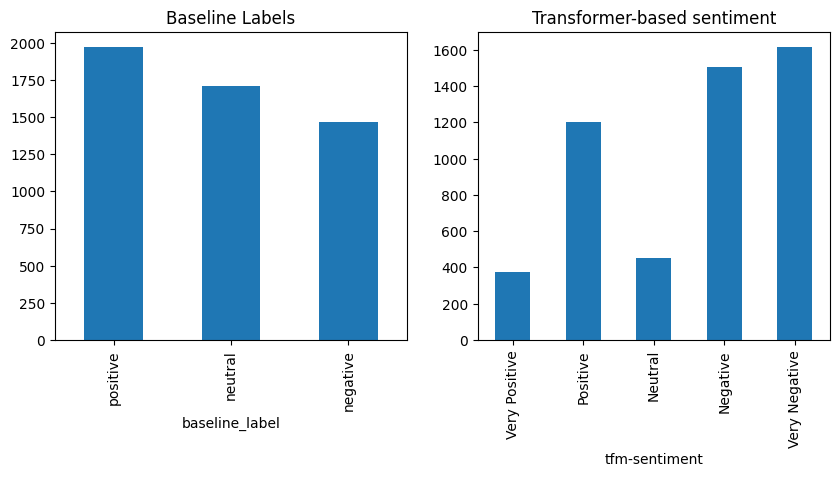


Comparison of Baseline Labels and Ground Truth Ratings:


attr_rating,negative,neutral,positive
baseline_label,,,
negative,1374,9,86
neutral,1378,21,310
positive,484,23,1467


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

order = ['Very Positive', 'Positive', 'Neutral', 'Negative', 'Very Negative']

fig, ax = plt.subplots(1,2, figsize=(10,4))
df["baseline_label"].value_counts().plot(kind="bar", ax=ax[0], title="Baseline Labels")
df["tfm-sentiment"].value_counts().loc[order].plot(kind="bar", ax=ax[1], title="Transformer-based sentiment")
plt.show()

# we have a NaN in the attr_rating, let's drop this one
df_nonans = df.dropna(subset=['attr_rating'])

# Create a crosstab to compare baseline labels and ground truth ratings
crosstab = pd.crosstab(df_nonans['baseline_label'], df_nonans['attr_rating'])

print("\nComparison of Baseline Labels and Ground Truth Ratings:")
display(crosstab)

## 5. Explore with Word Clouds

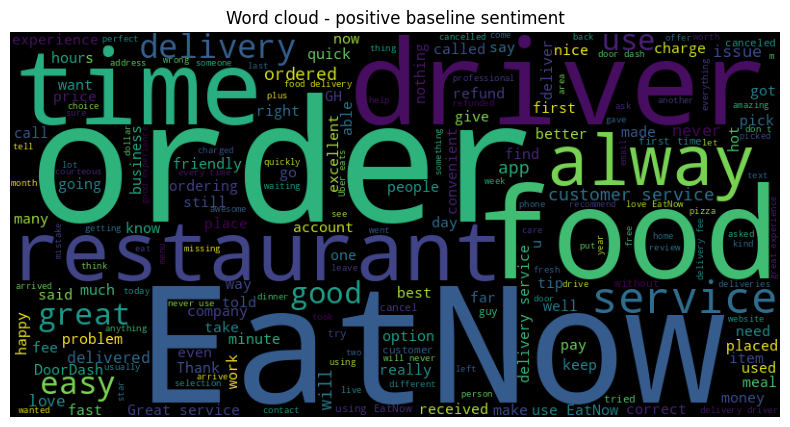

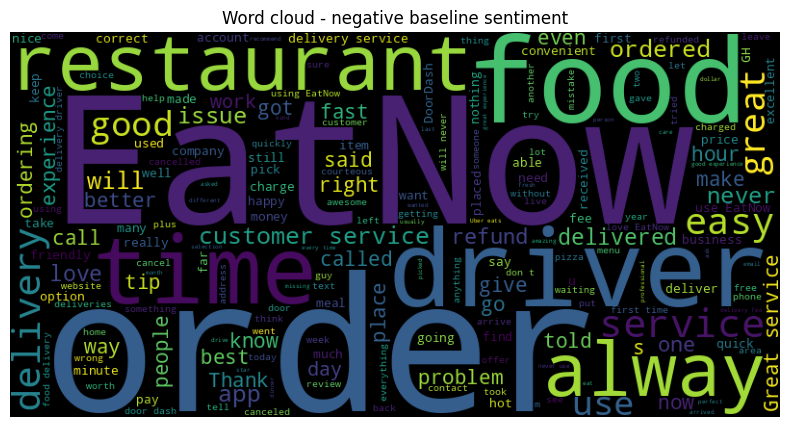

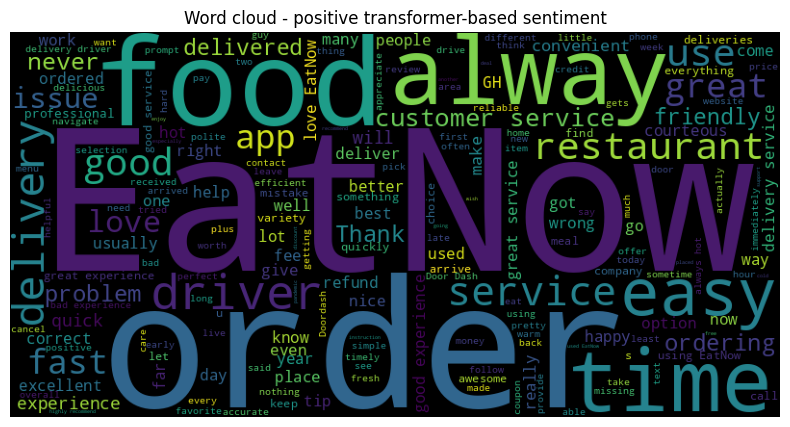

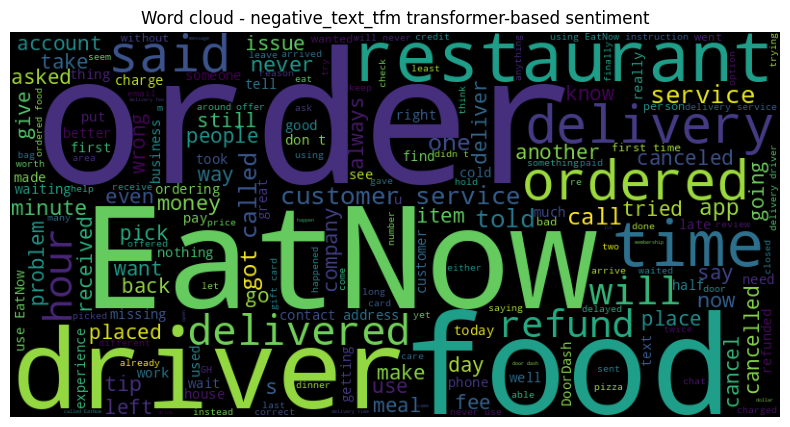

In [62]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_text_baseline = " ".join(df[df["baseline_label"]=="positive"]["text"].astype(str))
wc = WordCloud(width=800, height=400).generate(positive_text_baseline)
plt.figure(figsize=(10,5))
plt.title("Word cloud - positive baseline sentiment")
plt.imshow(wc)
plt.axis("off")
plt.show()

negative_text_baseline = " ".join(df[df["baseline_label"]=="negative"]["text"].astype(str))
wc = WordCloud(width=800, height=400).generate(positive_text_baseline)
plt.figure(figsize=(10,5))
plt.title("Word cloud - negative baseline sentiment")
plt.imshow(wc)
plt.axis("off")
plt.show()


positive_text_tfm = " ".join(df[df["tfm-sentiment"]=="Positive"]["text"].astype(str))
wc = WordCloud(width=800, height=400).generate(positive_text_tfm)
plt.figure(figsize=(10,5))
plt.title("Word cloud - positive transformer-based sentiment")
plt.imshow(wc)
plt.axis("off")
plt.show()

negative_text_tfm = " ".join(df[df["tfm-sentiment"]=="Negative"]["text"].astype(str))
wc = WordCloud(width=800, height=400).generate(negative_text_tfm)
plt.figure(figsize=(10,5))
plt.title("Word cloud - negative transformer-based sentiment")
plt.imshow(wc)
plt.axis("off")
plt.show()